In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

/anaconda2/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data reading

In [3]:
data = pd.read_csv('aapl_dataset.csv', index_col = 'Date')

In [4]:
data = data.dropna()

In [5]:
data.tail()

,high,low,open,close,volume,adj close,feat_RSI_close,feat_OBV_volume,feat_ATR_close,feat_HT_DCPERIOD_close,feat_HT_DCPHASE_close,feat_FUNDAMENTAL1_CHG,feat_FUNDAMENTAL2_CHG,feat_K10_FILING,feat_SENTIMENT_UP,feat_DIVIDEND
Date,,,,,,,,,,,,,,,,
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,283.596924,74.436585,2.224292e+10,3.913542,28.454955,150.076370,-0.337975,0.541358,3,0,-0.982111
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,289.223602,78.678994,2.226620e+10,4.041862,28.079039,153.345130,-0.408145,0.929980,0,1,-2.587859
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,289.113831,78.405656,2.222964e+10,4.171015,27.740405,156.893808,0.162783,0.732749,3,1,0.814541
2019-12-30,292.690002,285.220001,289.459991,291.519989,36028600.0,290.829773,79.598963,2.226566e+10,4.406657,27.553361,160.727817,-0.933116,0.980977,0,0,-1.696447
2019-12-31,293.679993,289.519989,289.929993,293.649994,25201400.0,292.954712,80.999258,2.229087e+10,4.389039,27.941882,164.208211,0.383039,0.336035,1,0,0.176790


In [6]:
t = '2015-01-01'
data_train = data[:t]
data_test = data[t:]

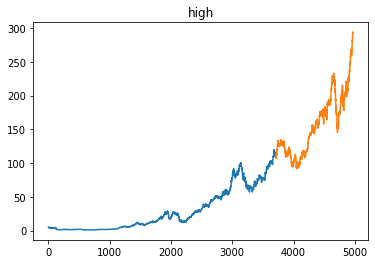

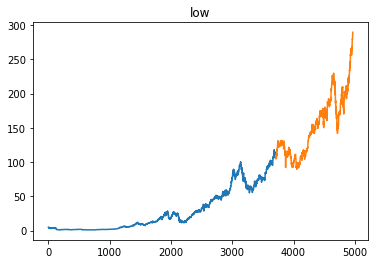

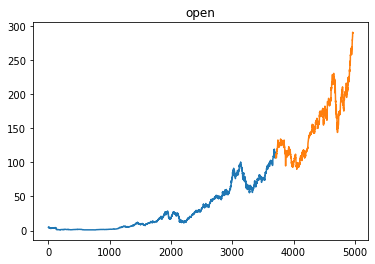

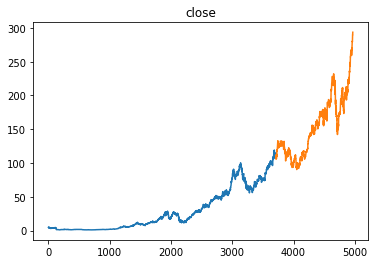

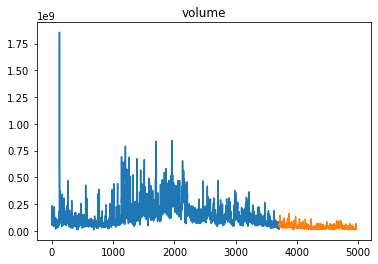

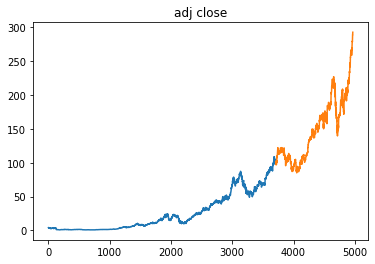

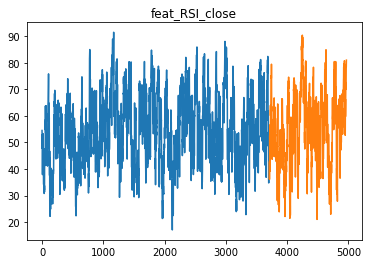

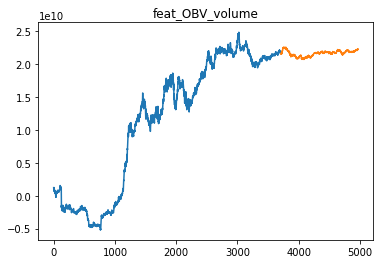

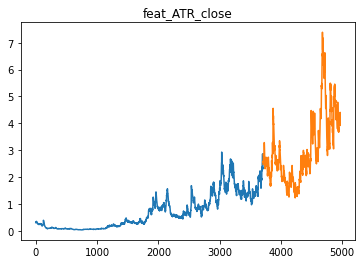

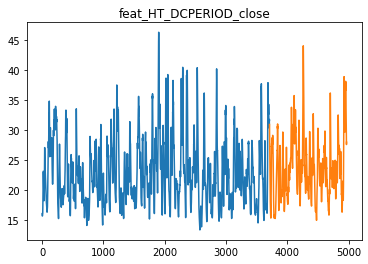

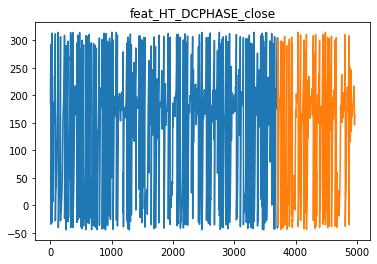

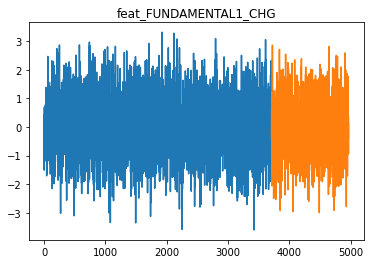

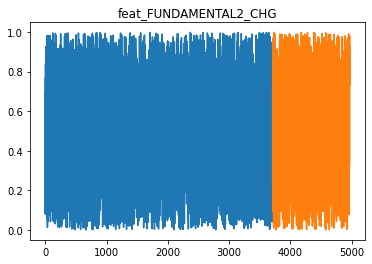

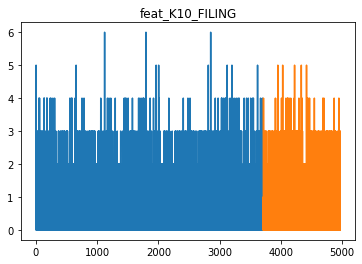

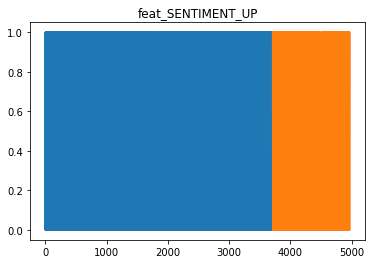

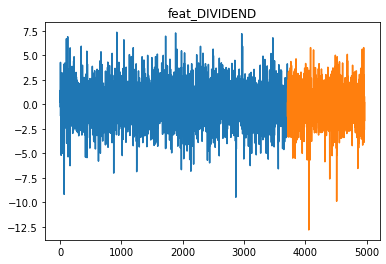

In [7]:
for column in data.columns:  
    plt.figure()
    plt.title(column)
    plt.plot(range(0, len(data_train)), data_train[column])
    plt.plot(range(len(data_train), len(data_train) + len(data_test)), data_test[column])
    plt.show()

# Data Preparation

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler_x = StandardScaler()
inputs_train = scaler_x.fit_transform(data_train)
inputs_test = scaler_x.transform(data_test)

scaler_y = StandardScaler()
outputs_train = scaler_y.fit_transform(data_train.close.values.reshape(-1, 1))
outputs_test = scaler_y.transform(data_test.close.values.reshape(-1, 1))

In [11]:
WINDOW = 14
HORIZON = 1

In [12]:
def createXY(inputs, outputs):   
    X, Y, Yb, P = [], [], [], []
    for i in range(WINDOW, len(inputs)-1, 1):

        window = inputs[i-WINDOW:i]
        future = outputs[i+HORIZON]
        future_binary = int(outputs[i] < future) # close price in the future higher than today?

        X.append(window)
        Y.append(future)
        Yb.append(future_binary)
        P.append(outputs[i])

    X, Y, Yb, P = np.array(X), np.array(Y), np.array(Yb), np.array(P)
    return X, Y, Yb, P

In [13]:
X_train, Y_train, Y_train_b, P_train = createXY(inputs_train, outputs_train)
X_test, Y_test, Y_test_b, P_test = createXY(inputs_test, outputs_test)

In [14]:
X_train.shape, Y_train.shape, Y_train_b.shape, X_test.shape, Y_test.shape, Y_test_b.shape

((3695, 14, 16), (3695, 1), (3695,), (1243, 14, 16), (1243, 1), (1243,))

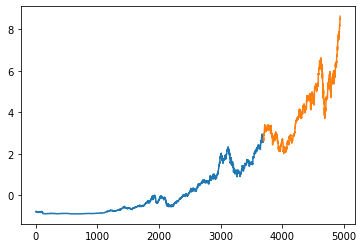

In [15]:
plt.figure()
plt.plot(range(0, len(Y_train)), Y_train)
plt.plot(range(len(Y_train), len(Y_train) + len(Y_test)), Y_test)
plt.show()

# Modeling

In [16]:
from keras.models import Model
from keras.layers import Dense, Dropout, GaussianNoise
from keras.layers import Input, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l1, l2 , l1_l2

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [17]:
def nn(shape):
    main_input = Input(shape=shape, name='main_input')
    x = Flatten()(main_input)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.25)(x)
    output = Dense(1, activation = "linear")(x)
    
    final_model = Model(inputs=[main_input], outputs=[output])
    return final_model

In [18]:
model = nn((WINDOW, X_train.shape[2], ))
model.summary()

model.compile(optimizer='adam', loss=['mse'])

checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, Y_train, 
              validation_data = (X_test, Y_test),
              epochs = 100, 
              batch_size = 16, 
              verbose=True, 
              callbacks=[checkpointer, es],
              shuffle=True
                )

model.load_weights("test.hdf5")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                11250     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,301
Trainable params: 11,301
Non-trainable params: 0
_________________________________________________________________
Train on 3695 samples, validate on 1243 samples
Epoch 1/100
3695/3695 [==============================] - 3s 759us/step - 

# Evaluation

In [19]:
pred_test = model.predict(X_test)

In [20]:
pred_test_inv = scaler_y.inverse_transform(pred_test)
real_test_inv = scaler_y.inverse_transform(Y_test)

In [21]:
print('scaled', mean_absolute_error(Y_test, pred_test), r2_score(Y_test, pred_test))
print('real', mean_absolute_error(real_test_inv, pred_test_inv), r2_score(real_test_inv, pred_test_inv))

scaled 0.14163647839108695 0.9772789419640315
real 4.355543374439831 0.977278936431887


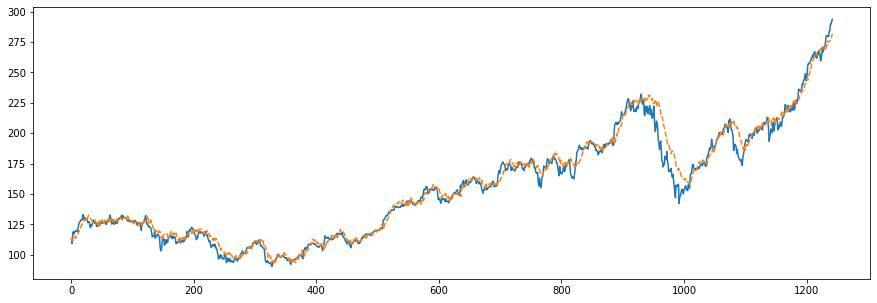

In [22]:
plt.figure(figsize = (15, 5))
plt.plot(real_test_inv)
plt.plot(pred_test_inv, ls = '--')
plt.show()

# Pseudo Backtest

In [23]:
signal = np.sign(pred_test - P_test)

In [24]:
backtest_df = pd.DataFrame(
    {
        'close': P_test.flatten(),
        'pred': pred_test.flatten(),
        'signal': signal.flatten()
    }
)

In [25]:
backtest_df['price_diff'] = backtest_df.close.shift(-1).pct_change()

In [26]:
backtest_df.head(10)

,close,pred,signal,price_diff
0,2.755613,2.787292,1.0,NaN
1,2.759515,2.703457,-1.0,-0.046665
2,2.630741,2.713845,1.0,0.076268
3,2.831381,2.720016,-1.0,0.041232
4,2.948123,2.799309,-1.0,-0.019193
5,2.891541,2.815980,-1.0,0.016532
6,2.939343,2.767761,-1.0,0.000221
7,2.939994,2.777780,-1.0,0.010065
8,2.969585,2.835957,-1.0,0.004161
9,2.981943,2.833498,-1.0,-0.011014


In [27]:
portfolio = backtest_df['price_diff'] * backtest_df['signal']

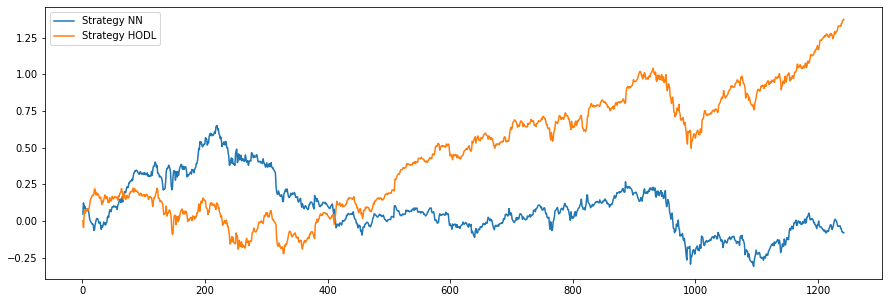

In [30]:
plt.figure(figsize = (15, 5))
plt.plot(portfolio.cumsum().values, label = 'Strategy NN')
plt.plot(pd.Series(P_test.flatten()).pct_change().cumsum(), label='Strategy HODL')
plt.legend()
plt.show()